In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import math
from datetime import datetime
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import holland_model as hm

################################################
#               PRE-PROCESSING                 #
################################################

In [2]:
# Function definitions
def haversine(lon1, lat1, lon2, lat2):
    # The radius of the Earth in kilometers and conversion from degrees to radians
    R, rad = 6371.0, math.radians
    dlon, dlat = rad(lon2 - lon1), rad(lat2 - lat1)
    a = math.sin(dlat / 2)**2 + math.cos(rad(lat1)) * math.cos(rad(lat2)) * math.sin(dlon / 2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

def calculate_speed(group):
    group.sort_values('ISO_TIME', inplace=True)
    time_diff = group['timeall'].diff().dt.total_seconds() / 3600
    distances = [0] + [haversine(lon1, lat1, lon2, lat2) for lon1, lat1, lon2, lat2 in zip(group['lonall'][:-1], group['latall'][:-1], group['lonall'][1:], group['latall'][1:])]
    group['STORM_MOVE_SPEED'] = np.divide(distances, time_diff / 24, out=np.zeros_like(distances), where=time_diff!=0)
    group['STORM_MOVE_SPEED'] = group['STORM_MOVE_SPEED'].fillna(0).abs()  # fill NaNs with 0 and take absolute value
    return group

# Data loading and preprocessing
df = pd.read_csv("ibtracs.NA.list.v04r00.csv", usecols=['SID','ISO_TIME', 'SEASON', 'LAT', 'LON', 'USA_LAT', 'USA_LON', 'WMO_WIND', 'USA_WIND', 'WMO_PRES', 'USA_PRES', 'USA_RMW', 'NATURE', 'STORM_SPEED', 'STORM_DIR'])
df = df[df['SEASON'] != 'Year']
df = df[df['SEASON'].astype(int) >= 1975]
df['yearall'] = df['SEASON'].astype(int)
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])
df['timeall'] = df['ISO_TIME']

# Handling missing values and data conversions
numeric_cols = ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'USA_LAT', 'USA_LON', 'USA_WIND', 'USA_PRES', 'USA_RMW', 'STORM_SPEED', 'STORM_DIR']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
placeholder = -9999.9
df['latall'] = df['LAT'].combine_first(df['USA_LAT']).fillna(placeholder).round(1).replace(placeholder, np.nan)
df['lonall'] = df['LON'].combine_first(df['USA_LON']).fillna(placeholder).round(1).replace(placeholder, np.nan)
df['windall'] = df['WMO_WIND'].combine_first(df['USA_WIND'])
df['presall'] = df['WMO_PRES'].combine_first(df['USA_PRES'])
df['rmaxall'] = df['USA_RMW']

# Storm movement speed calculation
df = df.groupby('SID').apply(calculate_speed)
df.reset_index(drop=True, inplace=True)
df.dropna(subset=['latall', 'lonall', 'windall', 'presall', 'rmaxall', 'STORM_SPEED', 'STORM_DIR', 'STORM_MOVE_SPEED'], inplace=True)

# Adjusting longitude values
df.loc[df['lonall'] < 0, 'lonall'] += 360

# Subset for a specific storm (e.g., Katrina)
subset_df = df[df['SID'] == '2005236N23285']

C:\Users\USER\AppData\Local\Temp\ipykernel_29340\680982985.py:18: DtypeWarning: Columns (1,8,9,19,20,23,24,161,162) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ibtracs.NA.list.v04r00.csv", usecols=['SID','ISO_TIME', 'SEASON', 'LAT', 'LON', 'USA_LAT', 'USA_LON', 'WMO_WIND', 'USA_WIND', 'WMO_PRES', 'USA_PRES', 'USA_RMW', 'NATURE', 'STORM_SPEED', 'STORM_DIR'])


################################################
#               HOLLAND MODEL                  #
################################################

In [42]:
# Function definitions
def Basins_WMO(basin):
    if basin=='EP': #Eastern Pacific
        lat0,lat1,lon0,lon1=5,60,180,285
    if basin=='NA': #North Atlantic
        lat0,lat1,lon0,lon1=5,60,255,359
    if basin=='NI': #North Indian
        lat0,lat1,lon0,lon1=5,60,30,100
    if basin=='SI': #South Indian
        lat0,lat1,lon0,lon1=-60,-5,10,135
    if basin=='SP': #South Pacific
        lat0,lat1,lon0,lon1=-60,-5,135,240
    if basin=='WP': #Western Pacific
        lat0,lat1,lon0,lon1=5,60,100,180

    return lat0,lat1,lon0,lon1


# Wind field calculation and data structures
basin = 'NA'
lat0, lat1, lon0, lon1 = Basins_WMO(basin)
res, alpha, beta_bg, SWRF, CF, tc_radius, Patm = 0.1, 0.55, 20., 0.85, 0.915, 1000., 101325.
max_distance = tc_radius / 110.
n_cols, n_rows = 36, 1000
latspace = np.arange(lat0 + res / 2., lat1 + res / 2., res) if lat0 > 0 else np.arange(lat0 - res / 2., lat1 - res / 2., res)
lonspace = np.arange(lon0 + res / 2., lon1 + res / 2., res)
points = [(i, j) for i in latspace for j in lonspace]
wind_field={i:[] for i in range(len(points))}
shadowlist = {kk: [] for kk in range(len(points))}
tree = spatial.cKDTree(points)

# Initialize a list to store the data
wind_data_records = []

# Wind field analysis loop
for SID, storm_df in df.groupby("SID"):
   
#loop over the different TCs
    latslice = storm_df["latall"].values.copy()
    lonslice = storm_df["lonall"].values.copy()
    windslice = storm_df["windall"].values.copy() * 0.5144  # 1 knot = 0.5144 m/s
    presslice = storm_df["presall"].values.copy()
    timeslice = storm_df["timeall"].values.copy()
    rmaxslice = storm_df["rmaxall"].values.copy() * 1.852  # 1 nautical mile = 1.852 km


    for j in range(1,len(latslice)):
      lat0,lat1,lon0,lon1,t0,t1=latslice[j-1],latslice[j],lonslice[j-1],lonslice[j],timeslice[j-1],timeslice[j]
      U10,Rmax,P=windslice[j],rmaxslice[j],presslice[j]
      dt_seconds = ((t1 - t0) / np.timedelta64(1, 's'))

      #Generate the seperate list of coastal points that are in the spyderweb
      distances, indices = tree.query((lat1,lon1),k=len(points), p=2,distance_upper_bound=max_distance)
      points_to_save=[points[indices[k]] for k in range(len(distances)) if distances[k]<max_distance]

      #Spyderweb step 1: Generate the spyderweb mesh --> predefined function!

      rlist,thetalist,xlist,ylist=hm.Generate_Spyderweb_mesh(n_cols,n_rows,tc_radius,lat0)

      latlist,lonlist=hm.Generate_Spyderweb_lonlat_coordinates(xlist,ylist,lat1,lon1)

      #Spyderweb step 2: Calculate the background wind --> predefined function!

      [bg,ubg,vbg]=hm.Compute_background_flow(lon0,lat0,lon1,lat1,dt_seconds)

      #Spyderweb step 3: Subtract the background flow from U10 (tropical cyclone's 10-meter wind speed)
      #For this, first convert U10 to surface level using the SWRF-constant
      #next, subtract a fraction alpha of the background flow.

      Usurf=(U10/SWRF)-(bg*alpha) #1-minute maximum sustained surface winds
      P_mesh=np.zeros((xlist.shape))
      Pdrop_mesh=np.zeros((xlist.shape))

      up=np.zeros((xlist.shape))
      vp=np.zeros((xlist.shape))

      #Spyderweb step 4: Calculate wind and pressure profile using the Holland model
      for l in range(1,n_rows):
          r=rlist[0][l]
          Vs,Ps=hm.Holland_model(lat1,P,Usurf,Rmax,r)
          Vs=Vs*SWRF      #Convert back to 10-min wind speed

          P_mesh[:,l].fill(Ps/100.)    #in Pa
          Pdrop_mesh[:,l].fill((Patm-Ps)/100.)   #in Pa

          beta=hm.Inflowangle(r,Rmax,lat0)

          for k in range(0,n_cols):
            ubp=alpha*(ubg*math.cos(math.radians(beta_bg))-np.sign(lat0)*vbg*math.sin(math.radians(beta_bg)))
            vbp=alpha*(vbg*math.cos(math.radians(beta_bg))+np.sign(lat0)*ubg*math.sin(math.radians(beta_bg)))

            up[k,l]=-Vs*math.sin(thetalist[:,0][k]+beta)+ubp
            vp[k,l]=-Vs*math.cos(thetalist[:,0][k]+beta)+vbp

      u10=CF*up
      v10=CF*vp
      windfield=np.sqrt(u10**2.+v10**2.)

      spy_points=[]
      wind_points=[]

      for k in range(n_cols):
        for l in range(n_rows):
          spy_points.append((latlist[k,l],lonlist[k,l]))
          wind_points.append(windfield[k,l])

      tree2=spatial.cKDTree(spy_points)
      current_time = storm_df["timeall"].iloc[j-1]

      #overlay the spyderweb grid with the regular grid
      for (lat,lon),idx in zip(points_to_save,range(len(points_to_save))):
        local_dist, local_ind = tree2.query((lat,lon),k=1, p=2,distance_upper_bound=max_distance)
        shadowlist[indices[idx]].append((wind_points[local_ind], current_time))

    for m in range(len(shadowlist)):
        if shadowlist[m] and np.max([wind_speed for wind_speed, _ in shadowlist[m]]) >= 18:
            lat, lon = points[m]
            wind_speeds = [wind_speed for wind_speed, _ in shadowlist[m]]
            times = [time for _, time in shadowlist[m]]

            # Append the data to the list
            wind_data_records.append({'SID': SID, 'lat': lat, 'lon': lon, 'time': times, 'wind_speeds': wind_speeds})

# Create DataFrame from the list
wind_data_df = pd.DataFrame(wind_data_records)

Save df

In [ ]:
wind_data_df.to_csv('wind_speeds.csv', index=False)

################################################
#                   PLOTTING                   #
################################################

C:\Users\USER\AppData\Local\Temp\ipykernel_29340\2721499714.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')


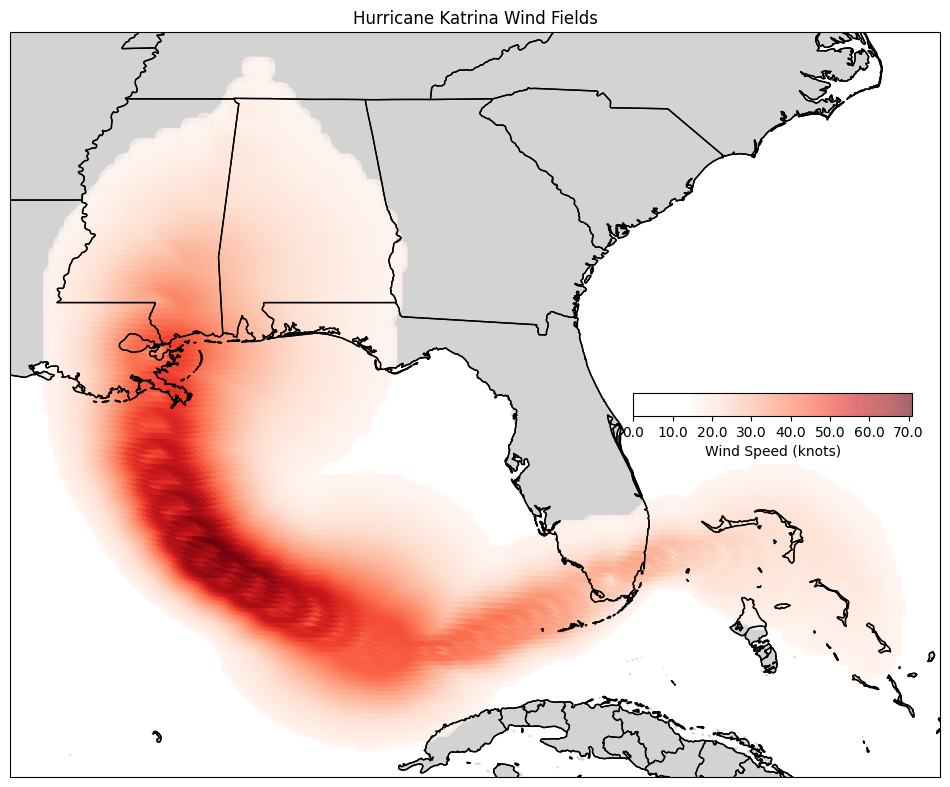

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create a figure with Cartopy projection
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title('Hurricane Katrina Wind Fields')

# Add map background (southeast USA)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, color='lightgray')

# Dictionary initialization for maximum wind speeds at each point
max_wind_speeds_at_points = {}

for idx, winds in shadowlist.items():
    lat, lon = points[idx]
    max_wind_speed = max(winds) if winds else 0
    max_wind_speeds_at_points[(lat, lon)] = max_wind_speed

# Filter and prepare wind speed data
filtered_wind_speeds = [max_wind_speed for (lat, lon), max_wind_speed in max_wind_speeds_at_points.items() if max_wind_speed >= 15]
filtered_latitudes = [lat for (lat, lon) in max_wind_speeds_at_points.keys() if max_wind_speeds_at_points[(lat, lon)] >= 15]
filtered_longitudes = [lon - 360 if lon > 180 else lon for (lat, lon) in max_wind_speeds_at_points.keys() if max_wind_speeds_at_points[(lat, lon)] >= 15]

# Plot the filtered wind field data with a continuous color map
cmap = plt.cm.get_cmap('Reds')
norm = plt.Normalize(min(filtered_wind_speeds), max(filtered_wind_speeds))
sc = ax.scatter(filtered_longitudes, filtered_latitudes, c=filtered_wind_speeds, cmap=cmap, s=np.array(filtered_wind_speeds) * 10, alpha=0.6, norm=norm)

# Create an inset axes for the colorbar with a white background
cb_ax = inset_axes(ax, width="30%", height="3%", loc='center right', borderpad=2)
cb_ax.patch.set_facecolor('white')
cb_ax.patch.set_alpha(1)
cb_ax.patch.set_edgecolor('black')

# Create a colorbar in the inset axes
cbar = fig.colorbar(sc, cax=cb_ax, orientation='horizontal')
cbar.set_label('Wind Speed (knots)')
cbar.set_ticks(np.arange(0, max(filtered_wind_speeds), 10))
cbar.set_ticklabels(np.arange(0, max(filtered_wind_speeds), 10))
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_21380\3375995720.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds')


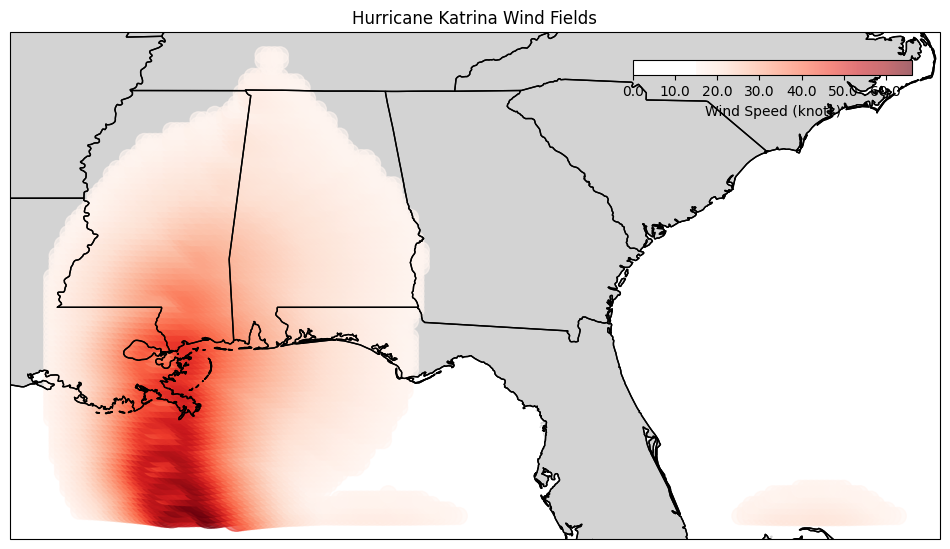

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create a figure with Cartopy projection
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title('Hurricane Katrina Wind Fields')

# Add map background (southeast USA)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, color='lightgray')

# Dictionary initialization for maximum wind speeds at each point
max_wind_speeds_at_points = {}

for idx, winds in shadowlist.items():
    lat, lon = points[idx]
    max_wind_speed = max(winds) if winds else 0
    max_wind_speeds_at_points[(lat, lon)] = max_wind_speed

# Filter and prepare wind speed data
all_wind_speeds = np.array([max_wind_speed for (lat, lon), max_wind_speed in max_wind_speeds_at_points.items() if max_wind_speed >= 15])
all_latitudes = np.array([lat for (lat, lon) in max_wind_speeds_at_points.keys() if max_wind_speeds_at_points[(lat, lon)] >= 15])
all_longitudes = np.array([lon - 360 if lon > 180 else lon for (lat, lon) in max_wind_speeds_at_points.keys() if max_wind_speeds_at_points[(lat, lon)] >= 15])

# Percentages for filtering
first_percent = 0
last_percent = 45

# Calculate indices for the first and last percentages
first_index = int(len(all_wind_speeds) * (first_percent / 100))
last_index = int(len(all_wind_speeds) * (1 - (last_percent / 100)))

# Filter the data
filtered_wind_speeds = np.concatenate((all_wind_speeds[:first_index], all_wind_speeds[last_index:]))
filtered_latitudes = np.concatenate((all_latitudes[:first_index], all_latitudes[last_index:]))
filtered_longitudes = np.concatenate((all_longitudes[:first_index], all_longitudes[last_index:]))

# Plot the filtered wind field data with a continuous color map
cmap = plt.cm.get_cmap('Reds')
norm = plt.Normalize(min(filtered_wind_speeds), max(filtered_wind_speeds))
sc = ax.scatter(filtered_longitudes, filtered_latitudes, c=filtered_wind_speeds, cmap=cmap, s=np.array(filtered_wind_speeds) * 10, alpha=0.6, norm=norm)

# Create an inset axes for the colorbar with a white background
cb_ax = inset_axes(ax, width="30%", height="3%", loc='upper right', borderpad=2)
cb_ax.patch.set_facecolor('white')
cb_ax.patch.set_alpha(1)
cb_ax.patch.set_edgecolor('black')

# Create a colorbar in the inset axes
cbar = fig.colorbar(sc, cax=cb_ax, orientation='horizontal')
cbar.set_label('Wind Speed (knots)')
cbar.set_ticks(np.arange(0, max(filtered_wind_speeds), 10))
cbar.set_ticklabels(np.arange(0, max(filtered_wind_speeds), 10))

plt.show()
